In [1]:
import pandas as pd
import numpy as np

from src.models import CapitalManager, DaoParams
from src.simulation import AllocationSimulator

In [2]:
dao_params = DaoParams(
    alpha=100,
    beta=0.1,
    premium=0.02,
    min_bond=50000,
    penalty=1.05,
    epoch_length_hours=24*28,
    auction_length=-1,
    ema_window_risk_free=24*7,
    ema_window_reputation=30*24,
    slash_percent=0.01
)

In [3]:
data = pd.read_csv(
    'data/into_the_block_data_2024.csv',
    parse_dates=['DateTime'],
    index_col='DateTime'
).drop(columns=["Borrow APY", "Supply APY"]).rename(
    columns={
        'Net APY': 'net_apy',
        'Staking APY': 'staking_apy'
    }
)

# assuming a 10x leverage on the data, we simply take 
# the risk free rate (stETH base rate) as:
data['staking_apy'] = data['staking_apy'] / 10
data.rename(columns={'staking_apy': 'risk_free_rate'}, inplace=True)

# the risk free rate goes through an exponential moving average (7-D)
data["ema_riskfree"] = data["risk_free_rate"].ewm(
    span=7*24,  # 7 days * 24 hours
    adjust=False  # Use traditional EMA calculation
).mean()

data.drop(columns=['risk_free_rate'], inplace=True)
data

,net_apy,ema_riskfree
DateTime,,
2024-01-25 17:00:00,0.095773,0.025986
2024-01-25 18:00:00,0.094889,0.025986
2024-01-25 19:00:00,0.094905,0.025987
2024-01-25 20:00:00,0.094896,0.025987
2024-01-25 21:00:00,0.095693,0.025987
...,...,...
2025-01-22 11:00:00,0.105806,0.024897
2025-01-22 12:00:00,0.085278,0.024896
2025-01-22 13:00:00,0.066021,0.024871


In [4]:
managers = []

In [5]:
managers.extend([
    CapitalManager(
        manager_id=f"CM_Risk",
        promised_yield=0,
        strategy_risk=0.7,
        bond_amount=100000,
        realized_yield=0,
        allocated_capital=0,
        absolute_returns=0,
        score=0,
        str_score='',
        reputation=1,
        score_history=None,
        to_penalise=False,
    ),
    CapitalManager(  # conservative
        manager_id=f"CM_Conservative",
        promised_yield=0,
        strategy_risk=0.2,
        bond_amount=100000,
        realized_yield=0,
        allocated_capital=0,
        absolute_returns=0,
        score=0,
        str_score='',
        reputation=1,
        score_history=None,
        to_penalise=False,
    ),
    CapitalManager(
        manager_id=f"CM_Moderate_1",
        promised_yield=0,
        strategy_risk=0.5,
        bond_amount=100000,
        realized_yield=0,
        allocated_capital=0,
        absolute_returns=0,
        score=0,
        str_score='',
        reputation=1,
        score_history=None,
        to_penalise=False,
    ),
    CapitalManager(
        manager_id=f"CM_Moderate_2",
        promised_yield=0,
        strategy_risk=0.5,
        bond_amount=100000,
        realized_yield=0,
        allocated_capital=0,
        absolute_returns=0,
        score=0,
        str_score='',
        reputation=1,
        score_history=None,
        to_penalise=False,
    )
])

In [6]:
simulator = AllocationSimulator(
    data=data,
    initial_managers=managers,
    dao_params=dao_params,
    initial_capital=10_000_000,
    strategy_liq_buffer=0.06,
)

In [7]:
print("Starting simulation...")
results = simulator.run_simulation()

# Analyze and display results
print("Simulation complete. Results summary:")
print(f"Total epochs simulated: {len(results)}")
print(f"Final total capital: {results.iloc[-1]['total_capital']:,.2f}")

Starting simulation...
$$$$$$$$$$$
epoch ID: 0
----
manager CM_Risk stats for epoch
manager was allocated 2500000.0 at the start
manager promised 0.10464002727231146 and realised 0.10044805284644191
manager's absolute profits in epoch: 19264.010134934066
manager scored 0.25292957824941503 and was allocated 2547161.3883431624

    score calculation components:
    yield: 9.300745633929806
    risk: 0.14484041942014797
    predictability: 0.0002864898768558541
    reputation: 1
    
new reputation score: 0.5467080894382228
----
manager CM_Conservative stats for epoch
manager was allocated 2500000.0 at the start
manager promised 0.08797848806551045 and realised 0.0818465615785823
manager's absolute profits in epoch: 15696.600850687018
manager scored 0.24414301203724226 and was allocated 2458675.089719372

    score calculation components:
    yield: 9.300745633929806
    risk: 0.14484041942014797
    predictability: 0.0002864898768558541
    reputation: 1
    
new reputation score: 0.5413

In [8]:
plot_df = results.copy()

columns = ['allocations', 'scores', 'promised_yields', 'realized_yields', 'reputation', 'absolute_returns', 'bond_amount']
        
# Unpack dictionary columns
for col in columns:
    expanded = plot_df[col].apply(pd.Series)
    expanded.columns = [f'{col}_{cid}' for cid in expanded.columns]
    plot_df = pd.concat([plot_df, expanded], axis=1)

plot_df

,epoch_id,total_capital,ema_risk_free,bid_floor,allocations,scores,promised_yields,realized_yields,bond_amount,absolute_returns,...,reputation_CM_Moderate_1,reputation_CM_Moderate_2,absolute_returns_CM_Risk,absolute_returns_CM_Conservative,absolute_returns_CM_Moderate_1,absolute_returns_CM_Moderate_2,bond_amount_CM_Risk,bond_amount_CM_Conservative,bond_amount_CM_Moderate_1,bond_amount_CM_Moderate_2
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-25 17:00:00,0,1.007063e+07,0.025836,0.045836,"{'CM_Risk': 2547161.3883431624, 'CM_Conservati...","{'CM_Risk': 0.25292957824941503, 'CM_Conservat...","{'CM_Risk': 0.10464002727231146, 'CM_Conservat...","{'CM_Risk': 0.10044805284644191, 'CM_Conservat...","{'CM_Risk': 100000, 'CM_Conservative': 100000,...","{'CM_Risk': 19264.010134934066, 'CM_Conservati...",...,0.545952,0.545685,19264.010135,15696.600851,17837.046421,17837.046421,100000.0,100000.0,100000.0,100000.0
2024-02-22 00:00:00,1,1.014594e+07,0.026683,0.046683,"{'CM_Risk': 2568520.3291415386, 'CM_Conservati...","{'CM_Risk': 0.2531573987319167, 'CM_Conservati...","{'CM_Risk': 0.09285164746924843, 'CM_Conservat...","{'CM_Risk': 0.10624137565011843, 'CM_Conservat...","{'CM_Risk': 100000, 'CM_Conservative': 100000,...","{'CM_Risk': 20759.42475948605, 'CM_Conservativ...",...,0.367214,0.366956,20759.424759,16327.470590,19127.025751,19093.551786,100000.0,100000.0,100000.0,100000.0
2024-03-21 00:00:00,2,1.021828e+07,0.026750,0.046750,"{'CM_Risk': 2587683.883915338, 'CM_Conservativ...","{'CM_Risk': 0.2532406683555457, 'CM_Conservati...","{'CM_Risk': 0.07743709019730623, 'CM_Conservat...","{'CM_Risk': 0.1012941027206988, 'CM_Conservati...","{'CM_Risk': 100000, 'CM_Conservative': 100000,...","{'CM_Risk': 19958.70393886973, 'CM_Conservativ...",...,0.296890,0.296642,19958.703939,15696.684541,18350.052876,18331.699855,100000.0,100000.0,100000.0,100000.0
2024-04-18 00:00:00,3,1.027957e+07,0.022280,0.042280,"{'CM_Risk': 2595107.178100049, 'CM_Conservativ...","{'CM_Risk': 0.252452950112615, 'CM_Conservativ...","{'CM_Risk': 0.07735532313042535, 'CM_Conservat...","{'CM_Risk': 0.08521456035945117, 'CM_Conservat...","{'CM_Risk': 100000, 'CM_Conservative': 100000,...","{'CM_Risk': 16915.70862048853, 'CM_Conservativ...",...,0.269407,0.269205,16915.708620,13300.695114,15543.433038,15528.491242,100000.0,100000.0,100000.0,100000.0
2024-05-16 00:00:00,4,1.034660e+07,0.024939,0.044939,"{'CM_Risk': 2615885.0720603717, 'CM_Conservati...","{'CM_Risk': 0.25282568987803195, 'CM_Conservat...","{'CM_Risk': 0.08564093588619141, 'CM_Conservat...","{'CM_Risk': 0.09264627416595744, 'CM_Conservat...","{'CM_Risk': 100000, 'CM_Conservative': 100000,...","{'CM_Risk': 18443.71592094366, 'CM_Conservativ...",...,0.258419,0.258436,18443.715921,14556.395507,17019.554525,17007.898910,100000.0,100000.0,100000.0,100000.0
2024-06-13 00:00:00,5,1.038811e+07,0.023164,0.043164,"{'CM_Risk': 2627039.8882627175, 'CM_Conservati...","{'CM_Risk': 0.2528890739409545, 'CM_Conservati...","{'CM_Risk': 0.049896762693320815, 'CM_Conserva...","{'CM_Risk': 0.05701004665218813, 'CM_Conservat...","{'CM_Risk': 100000, 'CM_Conservative': 100000,...","{'CM_Risk': 11440.242300980495, 'CM_Conservati...",...,0.254115,0.254224,11440.242301,9011.784349,10528.774233,10535.452852,100000.0,100000.0,100000.0,100000.0
2024-07-11 00:00:00,6,1.043322e+07,0.028176,0.048176,"{'CM_Risk': 2639619.7792935516, 'CM_Conservati...","{'CM_Risk': 0.2530014887325475, 'CM_Conservati...","{'CM_Risk': 0.049363719900118085, 'CM_Conserva...","{'CM_Risk': 0.06169189513257052, 'CM_Conservat...","{'CM_Risk': 100000, 'CM_Conservative': 100000,...","{'CM_Risk': 12432.542302142285, 'CM_Conservati...",...,0.252372,0.252532,12432.542302,9785.831901,11440.423500,11448.105433,100000.0,100000.0,100000.0,100000.0
2024-08-08 00:00:00,7,1.047315e+07,0.022320,0.042320,"{'CM_Risk': 2644735.5445302324, 'CM_Conservati...","{'CM_Risk': 0.25252523213673006, 'CM_Conservat...","{'CM_Risk': 0.05062547916258552, 'CM_Conservat...","{'CM_Risk': 0.05438225625464255, '

In [9]:
plot_df.dropna(inplace=True)
plot_df.drop(columns=["allocations", "scores", "realized_yields"], inplace=True)
plot_df

,epoch_id,total_capital,ema_risk_free,bid_floor,promised_yields,bond_amount,absolute_returns,reputation,allocations_CM_Risk,allocations_CM_Conservative,...,reputation_CM_Moderate_1,reputation_CM_Moderate_2,absolute_returns_CM_Risk,absolute_returns_CM_Conservative,absolute_returns_CM_Moderate_1,absolute_returns_CM_Moderate_2,bond_amount_CM_Risk,bond_amount_CM_Conservative,bond_amount_CM_Moderate_1,bond_amount_CM_Moderate_2
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-25 17:00:00,0,1.007063e+07,0.025836,0.045836,"{'CM_Risk': 0.10464002727231146, 'CM_Conservat...","{'CM_Risk': 100000, 'CM_Conservative': 100000,...","{'CM_Risk': 19264.010134934066, 'CM_Conservati...","{'CM_Risk': 0.5467080894382228, 'CM_Conservati...",2.547161e+06,2.458675e+06,...,0.545952,0.545685,19264.010135,15696.600851,17837.046421,17837.046421,100000.0,100000.0,100000.0,100000.0
2024-02-22 00:00:00,1,1.014594e+07,0.026683,0.046683,"{'CM_Risk': 0.09285164746924843, 'CM_Conservat...","{'CM_Risk': 100000, 'CM_Conservative': 100000,...","{'CM_Risk': 20759.42475948605, 'CM_Conservativ...","{'CM_Risk': 0.36859348395673946, 'CM_Conservat...",2.568520e+06,2.479132e+06,...,0.367214,0.366956,20759.424759,16327.470590,19127.025751,19093.551786,100000.0,100000.0,100000.0,100000.0
2024-03-21 00:00:00,2,1.021828e+07,0.026750,0.046750,"{'CM_Risk': 0.07743709019730623, 'CM_Conservat...","{'CM_Risk': 100000, 'CM_Conservative': 100000,...","{'CM_Risk': 19958.70393886973, 'CM_Conservativ...","{'CM_Risk': 0.2986020927167816, 'CM_Conservati...",2.587684e+06,2.497103e+06,...,0.296890,0.296642,19958.703939,15696.684541,18350.052876,18331.699855,100000.0,100000.0,100000.0,100000.0
2024-04-18 00:00:00,3,1.027957e+07,0.022280,0.042280,"{'CM_Risk': 0.07735532313042535, 'CM_Conservat...","{'CM_Risk': 100000, 'CM_Conservative': 100000,...","{'CM_Risk': 16915.70862048853, 'CM_Conservativ...","{'CM_Risk': 0.2706006722177452, 'CM_Conservati...",2.595107e+06,2.513633e+06,...,0.269407,0.269205,16915.708620,13300.695114,15543.433038,15528.491242,100000.0,100000.0,100000.0,100000.0
2024-05-16 00:00:00,4,1.034660e+07,0.024939,0.044939,"{'CM_Risk': 0.08564093588619141, 'CM_Conservat...","{'CM_Risk': 100000, 'CM_Conservative': 100000,...","{'CM_Risk': 18443.71592094366, 'CM_Conservativ...","{'CM_Risk': 0.2598155367467274, 'CM_Conservati...",2.615885e+06,2.528921e+06,...,0.258419,0.258436,18443.715921,14556.395507,17019.554525,17007.898910,100000.0,100000.0,100000.0,100000.0
2024-06-13 00:00:00,5,1.038811e+07,0.023164,0.043164,"{'CM_Risk': 0.049896762693320815, 'CM_Conserva...","{'CM_Risk': 100000, 'CM_Conservative': 100000,...","{'CM_Risk': 11440.242300980495, 'CM_Conservati...","{'CM_Risk': 0.25561284116776617, 'CM_Conservat...",2.627040e+06,2.537731e+06,...,0.254115,0.254224,11440.242301,9011.784349,10528.774233,10535.452852,100000.0,100000.0,100000.0,100000.0
2024-07-11 00:00:00,6,1.043322e+07,0.028176,0.048176,"{'CM_Risk': 0.049363719900118085, 'CM_Conserva...","{'CM_Risk': 100000, 'CM_Conservative': 100000,...","{'CM_Risk': 12432.542302142285, 'CM_Conservati...","{'CM_Risk': 0.2540283788466149, 'CM_Conservati...",2.639620e+06,2.549052e+06,...,0.252372,0.252532,12432.542302,9785.831901,11440.423500,11448.105433,100000.0,100000.0,100000.0,100000.0
2024-08-08 00:00:00,7,1.047315e+07,0.022320,0.042320,"{'CM_Risk': 0.05062547916258552, 'CM_Conservat...","{'CM_Risk': 100000, 'CM_Conservative': 100000,...","{'CM_Risk': 11011.938134427995, 'CM_Conservati...","{'CM_Risk': 0.25311633063249644, 'CM_Conservat...",2.644736e+06,2.559537e+06,...,0.252000,0.251800,11011.938134,8664.829788,10125.343478,10133.122851,100000.0,100000.0,100000.0,100000.0
2024-09-05 00:00:00,8,1.052121e+07,0.023903,0.043903,"{'CM_Risk': 0.06535565275681561, 'CM_Conservat...","{'CM_Risk': 100000, 'CM_Conservative': 100000,...","{'CM_Risk': 13228.015003645603, 'CM_Conservati...","{'CM_Risk': 0.2528812546032613, 'CM_Conservati...",2.659015e+06,2.571053e+06,...,0.251577,0.251678,13228.015004,10431.164159,12211.005292,12189.962629,100000.0,

<Axes: xlabel='timestamp'>

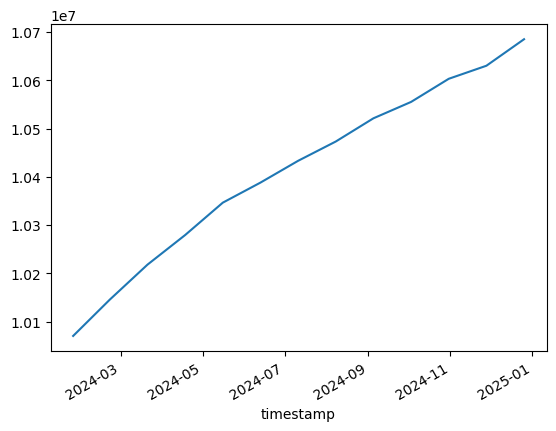

In [10]:
plot_df.dropna().total_capital.plot()

In [11]:
manager_ids = [m.manager_id for m in managers]
manager_ids

['CM_Risk', 'CM_Conservative', 'CM_Moderate_1', 'CM_Moderate_2']

<Axes: xlabel='timestamp'>

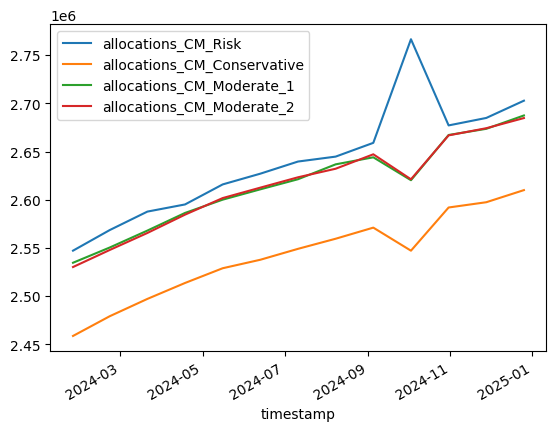

In [12]:
columns = [f'allocations_{m}' for m in manager_ids]
plot_df[columns].plot()

<Axes: xlabel='timestamp'>

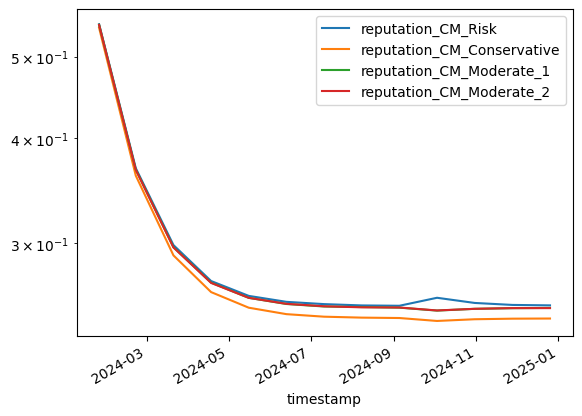

In [13]:
columns = [f'reputation_{m}' for m in manager_ids]
plot_df[columns].plot(logy=True)

<Axes: xlabel='timestamp'>

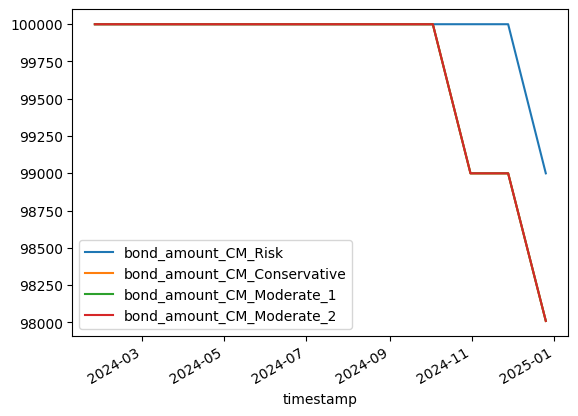

In [14]:
columns = [f'bond_amount_{m}' for m in manager_ids]
plot_df[columns].plot()

<Axes: xlabel='timestamp'>

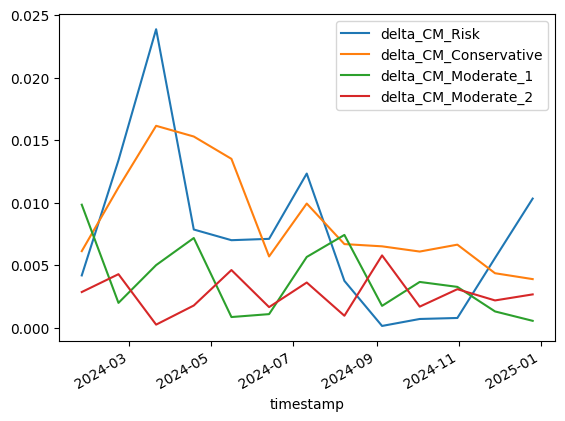

In [15]:
promised_yields_columns = [f'promised_yields_{m}' for m in manager_ids]
realized_yields_columns = [f'realized_yields_{m}' for m in manager_ids]

delta_cols = []
for m in manager_ids:
    plot_df[f'delta_{m}'] = (plot_df[f'promised_yields_{m}'] - plot_df[f'realized_yields_{m}']).abs()
    delta_cols.append(f'delta_{m}')


plot_df[delta_cols].plot()#(figsize=(10, 10), bins=30, range=(0, 0.03))